<a href="https://colab.research.google.com/github/mlaguna10/MLT_solutions/blob/master/Lab4_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 4 Machine Learning Techniques
# Segundo Problema


Ante la gran demanda de noticias que se generan hoy en día, el servicio público de radio y televisión Británica BBC desea realizar un sistema que le permita clasificar diferentes noticias para mostrarlas en su página web. Para ello, le ha brindado las noticias previamente clasificadas en cinco categorías. <br>

La idea es realizar un clasificador Näive Bayes para la realización de este problema.

In [1]:
import requests
f = requests.get("https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/README.TXT")
print(f.text)

Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
Natural Classes: 5 (business, entertainment, politics, sport, tech)

If you make use of the dataset, please consider citing the publication: 
- D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

All rights, including copyright, in the content of the original articles are owned by the BBC.

Contact Derek Greene <derek.greene@ucd.ie> for further information.
http://mlg.ucd.ie/datasets/bbc.html




# 0. Importando las librerias requeridas para el desarrollo del laboratorio

Librerias que no vienen en Colab

In [2]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install contractions
import nltk
nltk.download()

     |████████████████████████████████| 26.8MB 1.4MB/s 
     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 604kB 18.4MB/s 
     |████████████████████████████████| 3.1MB 36.3MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 296kB 46.8MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0rc1-py2.py3-none-any.whl size=258106 sha256=88770e8647a6f7ce5c754c479046e75e027b9c4a617b8788c4ea6689719059a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-9wiax9hu/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=6dd8910529b3429dc3f562ae73b0cc8c76fe05bd57c19654eb3956c33f60a01b
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for imagehash: filename=ImageHash

     |████████████████████████████████| 317kB 3.7MB/s 
     |████████████████████████████████| 245kB 17.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81708 sha256=420e7b4673d23a9647308246ad2afaafbbc7fd17c431cbb8751f14ff349decb6
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nlt

True

In [3]:
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Perfilamiento y entendimiento de los datos

### Lectura de los datos
Primero, se leen los datos y se visualizan que se hayan leido correctamente.

*Perfilamiento para Business*

In [8]:
for i in range(1,511):
  number = f'{i:03}'

  str1='https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/Noticias%20BBC/business/'
  str2='.txt'
  read_file=""

  try:
    read_file= pd.read_csv(f"{str1}{number}{str2}", delimiter='\n')
    read_file.to_csv ('result.csv', index=None ,mode='a', header=False)
  except:
    pass

In [12]:
fileObject= !cat result.csv

In [13]:
row_count = sum(1 for row in fileObject)
row_count

4352

In [14]:
col_Names=["Message", "Type"]
CSV_Business= pd.read_csv("result.csv",names=col_Names)
CSV_Business['Type'] = 'business'
CSV_Business.head()

,Message,Type
0,Quarterly profits at US media giant TimeWarner...,business
1,"The firm, which is now one of the biggest inve...",business
2,Time Warner said on Friday that it now owns 8%...,business
3,Time Warner's fourth quarter profits were slig...,business
4,TimeWarner is to restate its accounts as part ...,business


*Perfilamiento para Entertainment*

In [15]:
for i in range(1,387):
  number = f'{i:03}'
  #number = '001'

  str1='https://raw.githubusercontent.com/ramirovargas/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/Noticias%20BBC/entertainment/'
  str2='.txt'
  readfile=""

  try:
    read_file= pd.read_csv(f"{str1}{number}{str2}", delimiter='\t')
    read_file.to_csv ('resultE.csv', index=None ,mode='a', header=False)
  except:
    pass

In [16]:
fileObject= !cat resultE.csv

In [17]:
row_count = sum(1 for row in fileObject)
row_count

1720

In [18]:
col_Names=["Message", "Type"]
CSV_Entertainment= pd.read_csv("resultE.csv",names=col_Names)
CSV_Entertainment['Type'] = 'entertainment'
CSV_Entertainment.head()

,Message,Type
0,A Christmas tree that can receive text message...,entertainment
1,The spruce has an antenna which can receive Bl...,entertainment
2,The plain green Norway spruce is displayed in ...,entertainment
3,French musician Jean-Michel Jarre is to perfor...,entertainment
4,Denmark is holding a three-day celebration of ...,entertainment


*Perfilamiento para Politics*

In [19]:
for i in range(1,418):
  number = f'{i:03}'
  #number = '001'

  str1='https://raw.githubusercontent.com/ramirovargas/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/Noticias%20BBC/politics/'
  str2='.txt'
  readfile=""

  try:
    read_file= pd.read_csv(f"{str1}{number}{str2}", delimiter='\t')
    read_file.to_csv ('resultP.csv', index=None ,mode='a', header=False)
  except:
    pass


In [20]:
fileObject= !cat resultP.csv

In [21]:
row_count = sum(1 for row in fileObject)
row_count

2262

In [22]:
col_Names=["Message", "Type"]
CSV_Politics= pd.read_csv("resultP.csv",names=col_Names)
CSV_Politics['Type'] = 'politics'
CSV_Politics.head()

,Message,Type
0,Maternity pay for new mothers is to rise by £1...,politics
1,It would mean paid leave would be increased to...,politics
2,"Ms Hewitt said: ""We have already doubled the l...",politics
3,She said the Conservatives would announce thei...,politics
4,Ms Hewitt also stressed the plans would be pai...,politics


*Perfilamiento para Sports*

In [23]:
for i in range(1,512):
  number = f'{i:03}'
  #number = '001'

  str1='https://raw.githubusercontent.com/ramirovargas/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/Noticias%20BBC/sport/'
  str2='.txt'
  readfile=""

  try:
    read_file= pd.read_csv(f"{str1}{number}{str2}", delimiter='\t')
    read_file.to_csv ('resultS.csv', index=None ,mode='a', header=False)
  except:
    pass


In [24]:
fileObject= !cat resultS.csv

In [25]:
row_count = sum(1 for row in fileObject)
row_count

2302

In [26]:
col_Names=["Message", "Type"]
CSV_Sport= pd.read_csv("resultS.csv",names=col_Names)
CSV_Sport['Type'] = 'sport'
CSV_Sport.head()

,Message,Type
0,British hurdler Sarah Claxton is confident she...,sport
1,The 25-year-old has already smashed the Britis...,sport
2,"For the first time, Claxton has only been prep...",sport
3,Sonia O'Sullivan has indicated that she would ...,sport
4,Athletics Ireland have hinted that the 35-year...,sport


*Perfilamiento para Tech*

In [27]:
for i in range(1,402):
  number = f'{i:03}'
  #number = '001'

  str1='https://raw.githubusercontent.com/ramirovargas/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/Noticias%20BBC/tech/'
  str2='.txt'
  readfile=""

  try:
    read_file= pd.read_csv(f"{str1}{number}{str2}", delimiter='\t')
    read_file.to_csv ('resultT.csv', index=None ,mode='a', header=False)
  except:
    pass


In [29]:
fileObject= !cat resultT.csv

In [30]:
row_count = sum(1 for row in fileObject)
row_count

2170

In [31]:
col_Names=["Message", "Type"]
CSV_Tech= pd.read_csv("resultT.csv",names=col_Names)
CSV_Tech['Type'] = 'tech'
CSV_Tech.head()

,Message,Type
0,"The Kyrgyz Republic, a small, mountainous stat...",tech
1,This new technology is causing both worries an...,tech
2,The Kyrgyz Republic is seen by many experts as...,tech
3,The actual technology behind the ink is not th...,tech
4,"However, the presence of ultraviolet light (of...",tech


Union de la categorias

In [34]:
df = pd.concat([CSV_Business, CSV_Entertainment, CSV_Politics,CSV_Sport,CSV_Tech])
df

,Message,Type
0,Quarterly profits at US media giant TimeWarner...,business
1,"The firm, which is now one of the biggest inve...",business
2,Time Warner said on Friday that it now owns 8%...,business
3,Time Warner's fourth quarter profits were slig...,business
4,TimeWarner is to restate its accounts as part ...,business
...,...,...
2161,I bought the US version of World of Warcraft w...,tech
2162,Having played MMORPG games for some years I ag...,tech
2163,Unless there is undeniable medical proof that ...,tech
2164,These people are pathetic. They need to get of...,tech


#### Entendimiento de los Datos

Para entender los mensajes, se realizan 'estadísticas descriptivas' para poder obtener un análisis de los textos.

In [35]:
textos = df.copy()
textos['Conteo'] = [len(x) for x in textos['Message']]
textos['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in textos['Message']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Message']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Message']]

In [36]:
ProfileReport(textos)

### Análisis

*  Se observa un patron del estilo periodistico en algunos reportes en donde las misma frase se repite a pesar de ser de categorias diferentes.
*  Las palabras mas repetidas "the" and "of" son comunes entre las diferentes categorias, éstas no generarn mucho valor al momento de clasificar
*  Entre palabras y frases se notan pocos "Slangs" o palabras coloquiales, al tratarse de una narrativa periodistica lo cual favorece al momento del análisis.
*  A pesar de haber abreviaturas o palabras propias la libreria reconoce las palabras y nombres comunes.

# 2. Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Eliminación del Ruido.
* Tokenización.
* Normalización.

#### **3.1 Eliminación del Ruido**
La eliminación del ruido se utiliza para dejar el archivo en texto plano, sobre todo cuando vienen de diferentes fuentes como HTML, Twitter, XML, entre otros. También para eliminar caracteres especiales y pasar todo a minúscula.

In [37]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#### **3.2 Tokenización**
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos. 

In [38]:
df['Message'] = df['Message'].apply(contractions.fix) #Aplica la corrección de las contracciones

In [39]:
df['words'] = df['Message'].apply(word_tokenize)
df['words'] = df['words'].apply(preproccesing) #Aplica la eliminación del ruido
df.head()

,Message,Type,words
0,Quarterly profits at US media giant TimeWarner...,business,"[quarterly, profits, us, media, giant, timewar..."
1,"The firm, which is now one of the biggest inve...",business,"[firm, one, biggest, investors, google, benefi..."
2,Time Warner said on Friday that it now owns 8%...,business,"[time, warner, said, friday, owns, eight, sear..."
3,Time Warner's fourth quarter profits were slig...,business,"[time, warner, fourth, quarter, profits, sligh..."
4,TimeWarner is to restate its accounts as part ...,business,"[timewarner, restate, accounts, part, efforts,..."


#### **Normalización**
Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.

In [41]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [42]:
df['words'] = df['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
df.head()

,Message,Type,words
0,Quarterly profits at US media giant TimeWarner...,business,"[quart, profit, us, med, giant, timewarn, jump..."
1,"The firm, which is now one of the biggest inve...",business,"[firm, on, biggest, invest, googl, benefit, sa..."
2,Time Warner said on Friday that it now owns 8%...,business,"[tim, warn, said, friday, own, eight, searchen..."
3,Time Warner's fourth quarter profits were slig...,business,"[tim, warn, four, quart, profit, slight, bet, ..."
4,TimeWarner is to restate its accounts as part ...,business,"[timewarn, rest, account, part, effort, resolv..."


##### **3.4 Selección de campos**

Primero, se separa la variable predictora y los textos que se van a utilizar.

In [43]:
df['words'] = df['words'].apply(lambda x: ' '.join(map(str, x)))
df

,Message,Type,words
0,Quarterly profits at US media giant TimeWarner...,business,quart profit us med giant timewarn jump sevent...
1,"The firm, which is now one of the biggest inve...",business,firm on biggest invest googl benefit sal highs...
2,Time Warner said on Friday that it now owns 8%...,business,tim warn said friday own eight searchengin goo...
3,Time Warner's fourth quarter profits were slig...,business,tim warn four quart profit slight bet analyst ...
4,TimeWarner is to restate its accounts as part ...,business,timewarn rest account part effort resolv inqui...
...,...,...,...
2161,I bought the US version of World of Warcraft w...,tech,bought us vert world warcraft cam longest peri...
2162,Having played MMORPG games for some years I ag...,tech,play mmorpg gam year agr typ gam lif suck conc...
2163,Unless there is undeniable medical proof that ...,tech,unless undeny med proof star comput screens ho...
2164,These people are pathetic. They need to get of...,tech,peopl pathet nee get machin not world swift ov...


In [53]:
def to_number(x):
  if(x=='business'):
    return 0
  elif(x=='entertainment'):
    return 1
  elif(x=='politics'):
    return 2
  elif(x=='sport'):
    return 3
  elif(x=='tech'):
    return 4

In [55]:
df['Type_numerical'] = df['Type'].apply(lambda x: to_number(x))

In [56]:
X, y = df['words'],df['Type_numerical']
y.value_counts()

0    4352
3    2302
2    2262
4    2166
1    1720
Name: Type_numerical, dtype: int64

# 3. Modelamiento


### Entonación de parámetros

In [69]:
%%time 
from sklearn.naive_bayes import MultinomialNB

X_set, X_test, y_set, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
X_train, X_validation, y_train, y_validation = train_test_split(X_set, y_set, test_size=0.2, random_state=33)

estimators = [('transform', CountVectorizer(stop_words='english')), ('clf', MultinomialNB())]
pipe = Pipeline(estimators)

param_grid = {'clf__alpha': [0, 1, 5, 20, 100, 5000]}

grid_search = GridSearchCV(pipe, param_grid)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


{'clf__alpha': 1}
CPU times: user 21.2 s, sys: 63.1 ms, total: 21.2 s
Wall time: 21.3 s


In [70]:
%%time 
model = grid_search.best_estimator_
yfit = model.predict(X_validation)

CPU times: user 162 ms, sys: 979 µs, total: 163 ms
Wall time: 163 ms


In [73]:
print(classification_report(y_validation, yfit))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       704
           1       0.95      0.94      0.94       257
           2       0.91      0.96      0.94       369
           3       0.99      0.96      0.98       368
           4       0.95      0.97      0.96       351

    accuracy                           0.96      2049
   macro avg       0.95      0.96      0.96      2049
weighted avg       0.96      0.96      0.96      2049



Text(91.68, 0.5, 'predicted label')

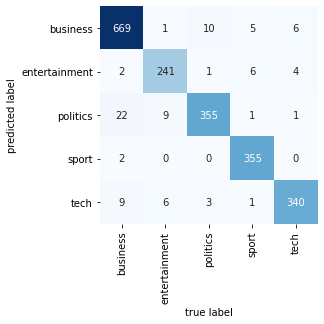

In [74]:
import seaborn as sns

mat = confusion_matrix(y_validation, yfit)
x_axis_labels = ['business','entertainment','politics','sport','tech']
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=x_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

Dado que tenemos buenos resultados para el conjunto de validación con el cual entonamos los parámetros, procedemos a usar el modelo sobre los datos de prueba.

# 4. Validación

In [76]:
ypred = model.predict(X_test)

In [77]:
print(classification_report(y_test, ypred,target_names=x_axis_labels))

               precision    recall  f1-score   support

     business       0.98      0.98      0.98       935
entertainment       0.99      0.97      0.98       314
     politics       0.98      0.98      0.98       428
        sport       0.99      0.98      0.99       439
         tech       0.96      0.98      0.97       445

     accuracy                           0.98      2561
    macro avg       0.98      0.98      0.98      2561
 weighted avg       0.98      0.98      0.98      2561



Text(91.68, 0.5, 'predicted label')

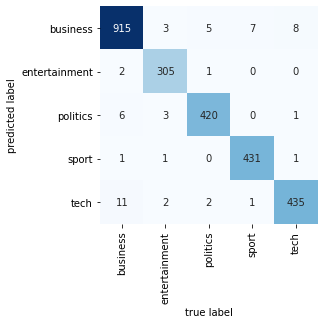

In [78]:
mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=x_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

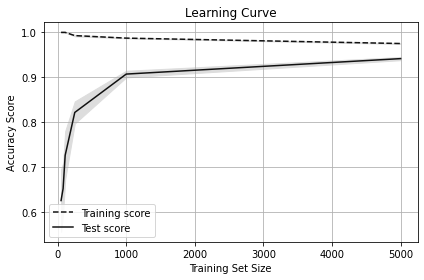

In [106]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=[50, 80, 110, 250, 1000, 5000], cv=5)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Test score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

La adaptación del código de la anterior gráfica se hizo con ayuda de: https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/